# Проект "Определение стоимости автомобилей"

## 1. Подготовка данных
### 1.1 Чтение фаила и вывод основной информации

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
import os
import time

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor

%matplotlib inline
pd.set_option('display.max_columns', 50)
pd.set_option("display.precision", 3)
sns.set_style(style='darkgrid')
np.random.seed(14)

Чтение фаила с данными

In [2]:
df = pd.read_csv('./datasets/autos.csv')

categorical_cols = df.select_dtypes(include=object).columns
numerical_cols = df.select_dtypes(exclude=object).columns

df.head()

DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0  2016-03-24 11:52:17    480         NaN              1993  manual      0   
1  2016-03-24 10:58:45  18300       coupe              2011  manual    190   
2  2016-03-14 12:52:21   9800         suv              2004    auto    163   
3  2016-03-17 16:54:04   1500       small              2001  manual     75   
4  2016-03-31 17:25:20   3600       small              2008  manual     69   

   Model  Kilometer  RegistrationMonth  FuelType       Brand NotRepaired  \
0   golf     150000                  0    petrol  volkswagen         NaN   
1    NaN     125000                  5  gasoline        audi         yes   
2  grand     125000                  8  gasoline        jeep         NaN   
3   golf     150000                  6    petrol  volkswagen          no   
4  fabia      90000                  7  gasoline       skoda          no   

           DateCreated  NumberOfPictures  PostalCode             LastSeen  
0  2016-03-24 00:00:00                 0       70435  2016-04-07 03:16:57  
1  2016-03-24 00:00:00                 0       66954  2016-04-07 01:46:50  
2  2016-03-14 00:00:00                 0       90480  2016-04-05 12:47:46  
3  2016-03-17 00:00:00                 0       91074  2016-03-17 17:40:17  
4  2016-03-31 00:00:00                 0       60437  2016-04-06 10:17:21

Вывод информации и основных характеристик датафрейма

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.describe()

Price  RegistrationYear       Power   Kilometer  \
count  354369.000        354369.000  354369.000  354369.000   
mean     4416.657          2004.234     110.094  128211.173   
std      4514.159            90.228     189.850   37905.342   
min         0.000          1000.000       0.000    5000.000   
25%      1050.000          1999.000      69.000  125000.000   
50%      2700.000          2003.000     105.000  150000.000   
75%      6400.000          2008.000     143.000  150000.000   
max     20000.000          9999.000   20000.000  150000.000   

       RegistrationMonth  NumberOfPictures  PostalCode  
count         354369.000          354369.0  354369.000  
mean               5.715               0.0   50508.689  
std                3.726               0.0   25783.096  
min                0.000               0.0    1067.000  
25%                3.000               0.0   30165.000  
50%                6.000               0.0   49413.000  
75%                9.000               0.0   71083.000  
max               12.000               0.0   99998.000

### 1.2 Предварительный исследовательский анализ данных

Для анализа данных используется библиотека pandas_profiling. Отчет сохранен в фаил "Autos_report.html"

In [5]:
df_profile = ProfileReport(df, title="Autos report", dark_mode=True, progress_bar=False, samples=None)
#df_profile.to_file("Autos_report.html") # сохранение отчета

C:\Users\user\anaconda3\lib\site-packages\scipy\stats\stats.py:4812: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Вызов сгенерированного отчета. Отчет сохранен в фаил Autos_report.html

In [6]:
df_profile.to_notebook_iframe()

### 1.3 Вывод:
В результате предварительного анализа данных обнаружено следующее:
1) Столбец NumberOfPictures полностью заполнен нулями;
2) В столбцах DateCrawled, DateCreated, LastSeen записаны данные о времени. Следует перевести в формат datatime.
3) Столбцы VehicleType, Gearbox, NotRepaired, FuelType, Model имеют пропущенные значения;
4) Имеются аномальные значения в столбце RegistrationYear, Power;
5) В столбцах Price, Power, RegistrationMonth имеются нулевые значения;
6) Имеется небольшое количество дубликатов.

## 2. Пердобработка данных
Для использования данных в обучении моделей машинного обучения некоторые колонки необходимо предобработать.

In [7]:
# копирование исходного датафрейма
processed_df = df.copy()

### 2.1 Удаление дубликатов и лишних столбцов

* Удалим обнаруженные дубликаты;
* Удалим столбец NumberOfPictures так как он полностью состоит из нулей;
* Так как столбец PostalCode содержит большое количество уникальных значений почтовых индексов, то он не несёт значимой информации для обучения ML моделей. Следовательно, его можно удалить.

In [8]:
# удаление дубликатов в исходном датафрейме
df.drop_duplicates(inplace=True)

# удаление столбцов NumberOfPictures и PostalCode
processed_df.drop(['NumberOfPictures', 'PostalCode'], axis=1, inplace=True)

### 2.2 Обработка столбцов с информацией о времени

Построим графики столбцов RegistrationYear, RegistrationMonth

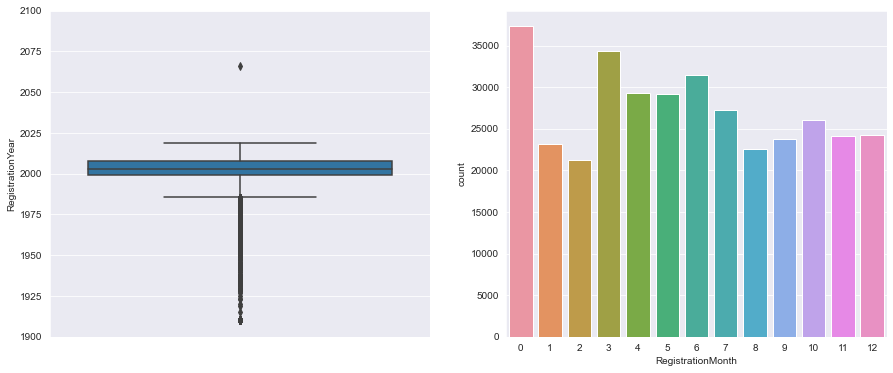

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.boxplot(y=processed_df['RegistrationYear'], ax=axes[0])
sns.countplot(data=processed_df, x='RegistrationMonth', ax=axes[1])

axes[0].set_ylim(1900, 2100);

Из графиков видно, что в столбце RegistrationYear имеются выбросы. В столбце RegistrationMonth имеется нулевой месяц.

Все значения в столбце RegistrationYear, которые выходят за границу усов диаграммы разброса заменим значениями границ. В столбце RegistrationMonth нулевой месяц заменим cлучайным месяцем.

In [10]:
def get_box_bound(data, col):
    """Функция рассчитывает нижнюю и верхнюю границы усов
    диаграммы размаха"""
    
    Q75 = data[col].quantile(0.75)
    Q25 = data[col].quantile(0.25)
    IQR = Q75 - Q25
    low_bound = np.floor(Q25 - IQR * 1.5)
    hight_bound = np.ceil(Q75 + IQR * 1.5)
    
    return low_bound, hight_bound

In [11]:
#расчет границ диаграммы размаха
low, hight = get_box_bound(processed_df, 'RegistrationYear')

#замена аномальных значений в столбце RegistrationYear
processed_df['RegistrationYear'].where(processed_df['RegistrationYear'] > low, low, inplace=True)
processed_df['RegistrationYear'].where(processed_df['RegistrationYear'] < hight, hight, inplace=True)

#замена аномальных значений в столбце RegistrationMonth
processed_df['RegistrationMonth'] = processed_df['RegistrationMonth'].apply(lambda x: np.random.randint(1, 12) if x == 0 else x)

Столбцы 'DateCrawled', 'DateCreated', 'LastSeen' приведем к типу datetime. Данные в этих столбцах разобъем на отдельные столбцы с информацией о дне, месяце, годе.

Функция преобразования столбцов с информацией о времени.

In [12]:
def split_dates(data, columns, split=False):
    """Приводит данные к типу datetime. Разделяет данные о времени на год, месяц и день"""
    
    
    # цикл по названия столбцов, содержащих время
    col_list = []
    for col in columns:
        # преобразование столбца в тип datetime
        data.loc[:, col] = pd.to_datetime(data.loc[:, col])
        
        # разделение данных о бремени на составляющие - год, месяц, день
        if split:
            
            # имя нового столбца
            col_name_year = 'Year_' + col
            col_name_month = 'Month_' + col
            col_name_day = 'Day_' + col
            
            col_list.append(col_name_year)
            col_list.append(col_name_month)
            col_list.append(col_name_day)
            
            # заполнение новых столбцов
            data.loc[:, col_name_year] = data.loc[:, col].dt.year
            data.loc[:, col_name_month] = data.loc[:, col].dt.month
            data.loc[:, col_name_day] = data.loc[:, col].dt.day
            
            # удаление исходного столбца
            data.drop(columns=col, inplace=True)
    # возврат списка наименований новых столбцов    
    return col_list

In [13]:
# создание списка с именами столбцов, содержащих информацию о времени и их преобразование
columnsWithDates = ['DateCrawled', 'DateCreated', 'LastSeen']

# сохранение списка созданных столбцов с информацией о времени
date_cols = split_dates(processed_df, columnsWithDates, split=True)

Построим графики значений новых столбцов

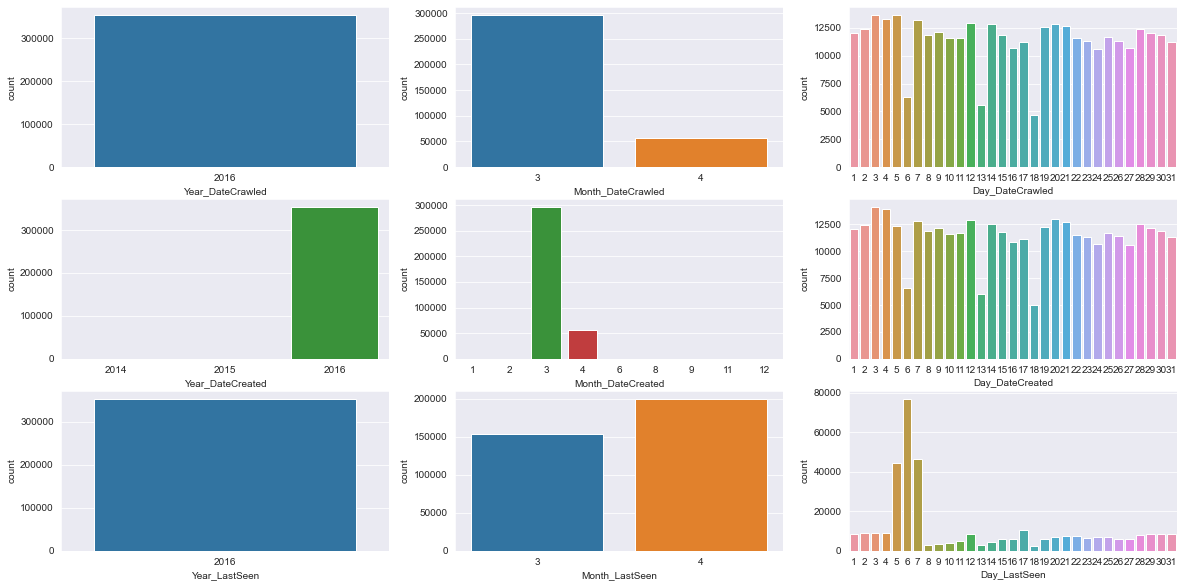

In [14]:
fig, axes = plt.subplots(3, 3, figsize=(20, 10))
i = 0
j = 0
for n, col in enumerate(date_cols):
    if n % 3 == 0 and n != 0:
        i += 1
        j = 0
    
    sns.countplot(data=processed_df, x=col, ax=axes[i][j])
    j += 1

Построим график тепловой карты корреляций новых столбцов

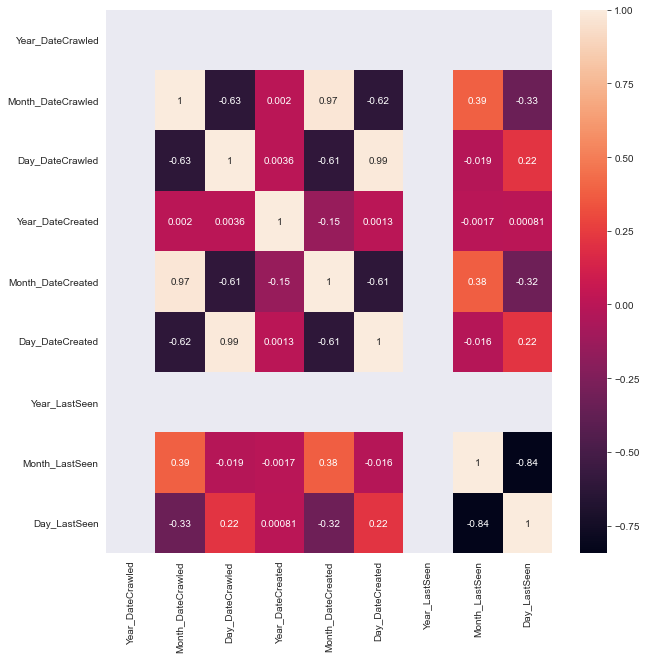

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(processed_df[date_cols].corr(), annot=True);

Из построенных графиков видно:
* столбцы Year_DateCrawled, Year_LastSeen имеют только одно уникальное значение;
* столбцы Month_DateCreated, Day_DateCrawled, Month_DateCreated, Day_DateCreated, Month_LastSeen, Day_LastSeen сильно коррелируют между собой

Исходя из полученных графиков целесообразно оставить информацию только о годе и месяце создания анкеты так как остальные столбцы имеют либо очень маленькое количество уникальных значений, либо сильно коррелируют между собой.

In [16]:
# удаление лишних столбцов с датами
processed_df.drop(['Year_DateCrawled', 'Month_DateCrawled', 'Day_DateCrawled', 'Year_LastSeen', 'Month_LastSeen', 'Day_LastSeen', 'Day_DateCreated'],
                  axis=1, inplace=True)

processed_df.head()

Price VehicleType  RegistrationYear Gearbox  Power  Model  Kilometer  \
0    480         NaN              1993  manual      0   golf     150000   
1  18300       coupe              2011  manual    190    NaN     125000   
2   9800         suv              2004    auto    163  grand     125000   
3   1500       small              2001  manual     75   golf     150000   
4   3600       small              2008  manual     69  fabia      90000   

   RegistrationMonth  FuelType       Brand NotRepaired  Year_DateCreated  \
0                  9    petrol  volkswagen         NaN              2016   
1                  5  gasoline        audi         yes              2016   
2                  8  gasoline        jeep         NaN              2016   
3                  6    petrol  volkswagen          no              2016   
4                  7  gasoline       skoda          no              2016   

   Month_DateCreated  
0                  3  
1                  3  
2                  3  
3                  3  
4                  3

### 2.3 Обработка столбцов с числовыми значениями

Построим диаграммы разброса столбцов Price и Power, в которых имеются аномальные числовые значения

(-10.0, 800.0)

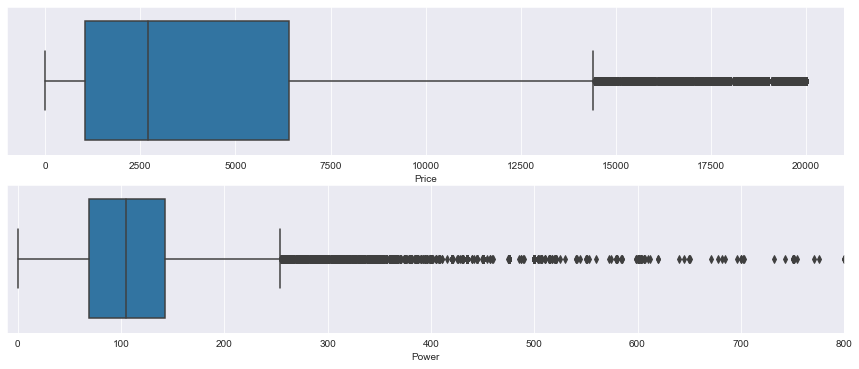

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(15, 6))
sns.boxplot(x=processed_df['Price'], ax=axes[0])
sns.boxplot(x=processed_df['Power'], ax=axes[1])

axes[1].set_xlim(-10, 800)

Из диаграмм разброса видно, что столбец Power имеет нулевые значения и аномально высокие значения. Столбец Price так же имеет нулевые значения.
Исходя из того, что цена и мощность автомобиля не могут быть равна нулю, а мощность автомобиля не может быть очень большой, отредактируем значения в этих столбцах. 

* Для столбца Price за нижнею границу примем значение 0.15 квантиля;
* Для столбца Power за нижнею границу примем значение 0.15 квантиля, за верхнею границу значение 0.99 квантиля.

In [18]:
# редактирование значений столбца Price
price_low_bound = processed_df['Price'].quantile(0.15)
processed_df['Price'].where(processed_df['Price'] > price_low_bound, price_low_bound, inplace=True)

# редактирование значений столбца Power
power_low_bound = processed_df['Power'].quantile(0.15)
power_hight_bound = processed_df['Power'].quantile(0.99)

processed_df['Power'].where(processed_df['Power'] > power_low_bound, power_low_bound, inplace=True)
processed_df['Power'].where(processed_df['Power'] < power_hight_bound, power_hight_bound, inplace=True)

### 2.4 Обработка пропущенных и текстовых значений
Перекодируем значения в столбце NotRepaired. Заполним пропуски в столбцах с категориальными значениями меткой other

In [19]:
# перекодирование столбца NotRepaired и заполнение пропусков меткой False
processed_df['NotRepaired'] = processed_df['NotRepaired'].map({'yes': True, 'no': False}).fillna(False)

# заполнение пропущенных значений в столбцах с категориальными значениями меткой other
for col in ['VehicleType', 'Gearbox', 'Model', 'FuelType']:
    processed_df.loc[:, col].fillna('other', inplace=True)

### 2.5 Вывод:
Отобразим итоговый датафрейм и таблицу корреляции столбцов таблицы.

In [20]:
# изменение порядка датафрейма
processed_df = processed_df.loc[:, ('Price','Power', 'Kilometer', 'VehicleType', 'Gearbox',
                                    'Model', 'FuelType', 'Brand', 'NotRepaired', 'RegistrationYear',
                                    'RegistrationMonth', 'Year_DateCreated', 'Month_DateCreated')
                               ]

# вывод обработанного датафрейма
processed_df.head()

Price  Power  Kilometer VehicleType Gearbox  Model  FuelType       Brand  \
0    650     54     150000       other  manual   golf    petrol  volkswagen   
1  18300    190     125000       coupe  manual  other  gasoline        audi   
2   9800    163     125000         suv    auto  grand  gasoline        jeep   
3   1500     75     150000       small  manual   golf    petrol  volkswagen   
4   3600     69      90000       small  manual  fabia  gasoline       skoda   

   NotRepaired  RegistrationYear  RegistrationMonth  Year_DateCreated  \
0        False              1993                  9              2016   
1         True              2011                  5              2016   
2        False              2004                  8              2016   
3        False              2001                  6              2016   
4        False              2008                  7              2016   

   Month_DateCreated  
0                  3  
1                  3  
2                  3  
3                  3  
4                  3

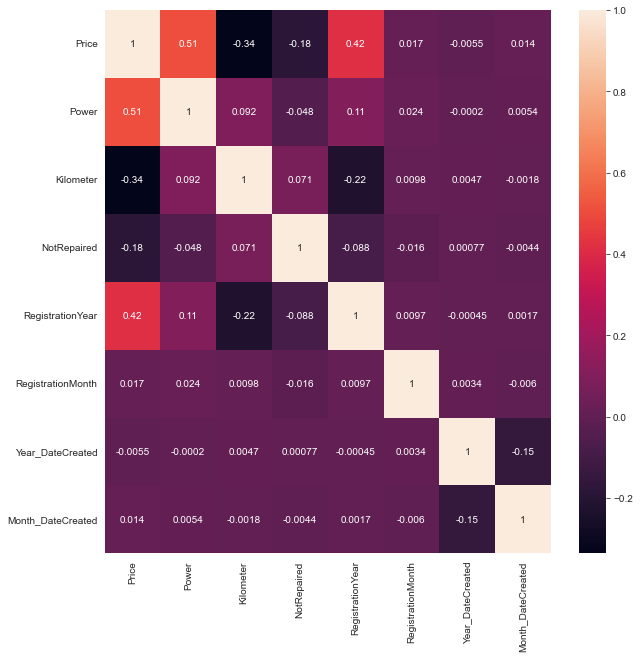

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(processed_df.corr(), annot=True);

В результате предобработки данных сделано следующее:

1) Удалены дубликаты из сходного датафрейма;
2) Удален столбец NumberOfPictures, состоящий полностью из нулей;
3) Преобразованы столбцы, содержащие информацию о времени;
4) Отредактированы аномальные значения в столбцах Price, Power, RegistrationYear, RegistrationMonth;
4) Перекодированы значения столбца NumberOfPictures;
5) Заполнены пропущенные значения в столбцах с категориальными признаками.

## 3. Обучение моделей

### 3.1 Подготовка данных

Функция, преобразующая входной датасет в необходимый для обучения моделей формат

In [22]:
def preparing_data_for_ML(X_train, X_test, num_col_in, categor_col_in, like_DF=False):
    """Масштабирует числовые значения. Кодирует категориальные значения методом OHE.
       Выводит результат в виде массива или датафрейма."""
    
    # масштабирование
    scaler = StandardScaler()
    scaler.fit(X_train[num_col_in])
    scalered_X_train = scaler.transform(X_train[num_col_in])
    scalered_X_test = scaler.transform(X_test[num_col_in])

    
    # One-Hot кодирование
    ohe = OneHotEncoder(drop='first', sparse=False)
    ohe.fit(X_train[categor_col_in])
    encoded_X_train = ohe.transform(X_train[categor_col_in])
    encoded_X_test = ohe.transform(X_test[categor_col_in])

    # слияние перекодировынных признаков
    processed_X_train = np.hstack((scalered_X_train, encoded_X_train))
    processed_X_test = np.hstack((scalered_X_test, encoded_X_test))
    
    # если True, выводит итого в виде датафрейма
    if like_DF:
        df_col = np.hstack((scaler.feature_names_in_, ohe.get_feature_names_out(categor_col_in)))
        df_out_train = pd.DataFrame(data=processed_X_train, columns=df_col)
        df_out_test = pd.DataFrame(data=processed_X_test, columns=df_col)
        return df_out_train, df_out_test
    
    return processed_X_train, processed_X_test

Подготовка данных для обучения ML моделей

In [23]:
data = processed_df.copy()

# создание списков с категориальными и числовыми колонками
cat_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand',
            'NotRepaired','RegistrationYear', 'RegistrationMonth', 'Year_DateCreated',
            'Month_DateCreated']

num_cols = [*filter(lambda x: x not in cat_cols and x != 'Price', data.columns)]

# определение признаков и целевого признака
X = data.drop('Price', axis=1)
y = data['Price']

# разбиение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=14)

# обработка числовых и категориальных данных с помощью функции "preparing_data_for_ML"
X_train, X_test = preparing_data_for_ML(X_train, X_test, num_cols, cat_cols, like_DF=False)

# проверка размерности выборок
print(f'Размеры выборок с признаками: Train = {X_train.shape}, Test = {X_test.shape}')
print(f'Размеры выборок с целевым признаком:  Train = {y_train.shape}, Test = {y_test.shape}')

Размеры выборок с признаками: Train = (265776, 362), Test = (88593, 362)
Размеры выборок с целевым признаком:  Train = (265776,), Test = (88593,)


### 3.2 Обучение моделей и поиск гиперпараметров

Функция для поиска гиперпараметров и получения метрики RMSE на кросс-валидации

In [24]:
def grid_search_param(model, parametrs, X_train=X_train, y_train=y_train, cv=5, info=True):
    """С помощью метода GridSearchCV ищет лучшие гиперпараметры модели.
    Выводит полученную на кросс-валидации метрику RMSE."""
    
    grid = GridSearchCV(estimator=model,
                    param_grid=parametrs,
                    scoring='neg_root_mean_squared_error',
                    cv=cv,
                    n_jobs=-1,
                    verbose=False)
    grid.fit(X_train, y_train)
    
    if info:
        print('\nНаилучшее значение метрики качества RMSE ровна: {0}'.format(abs(grid.best_score_.round(5))))
        print('Параметры модели: ', grid.best_params_, '\n')
        
    return grid.best_params_, abs(grid.best_score_)

#### 3.2.1 Обучение модели линейной регрессии

In [25]:
model_Ridge = Ridge(random_state=14)

params_Ridge = {'alpha': [0.05, 0.1, 0.5]}

Ridge_best_param, Ridge_valid_score = grid_search_param(model_Ridge, params_Ridge, cv=3)


Наилучшее значение метрики качества RMSE ровна: 2235.87982
Параметры модели:  {'alpha': 0.1} 



#### 3.2.2 Обучение модели DecisionTreeRegressor

In [26]:
model_DT = DecisionTreeRegressor(random_state=14)

params_DT = {'min_samples_split': [80, 100],
          'max_depth': [15, 20]}

DT_best_param, DT_valid_score = grid_search_param(model_DT, params_DT, cv=3)


Наилучшее значение метрики качества RMSE ровна: 2100.19362
Параметры модели:  {'max_depth': 20, 'min_samples_split': 80} 



#### 3.2.3 Обучение модели градиентного бустинга LightGBM 

In [27]:
model_LGBR = LGBMRegressor(random_state=14)

params = params = {'max_depth': [4, 6],
                   'learning_rate': [0.1, 0.5],
                   'n_estimators': [200, 300]}


LGBR_best_param, LGBR_valid_score = grid_search_param(model_LGBR, params, cv=3)


Наилучшее значение метрики качества RMSE ровна: 1781.58509
Параметры модели:  {'learning_rate': 0.5, 'max_depth': 6, 'n_estimators': 300} 



### 3.3 Проверка моделей на тестовой выборке

Обучим каждую модель с подобранными гиперпараметрами на тестовой выборке и получим метрику качества RMSE на предсказанных данных. Измерим время обучения и предсказания моделей. Выведем значение метрики качестка RMSE для модели LGBM, так как она имеет наилучший показатель на RMSE на кросс-валидации.

In [28]:
# функция-декоратор выводящая время работы функции
def time_decorator(functions):
    """Выводит время работы декорируемой функции"""
    # функция подсчета времени работы
    def test_time(*args, **kwargs):
        start = time.time()
        result = functions(*args, **kwargs)
        end = time.time()
        delta_time = end - start
        #print(f"Время работы модели равно: {round(delta, 3)} сек")
        return delta_time, result
    return test_time


# декорированная функция, возвращающая время обучения модели
@time_decorator
def get_fit_time(model, X_tr, y_tr):
    model.fit(X=X_tr, y=y_tr)

    
# декорированная функция, возвращающая время предсказания модели    
@time_decorator  
def get_predict_time(model, X):
    y_pred = model.predict(X)
    return y_pred


# функция подсчета метрики качества RMSE на тестовой выборке
def model_testing(model, y_test, y_pred, info=False):
    """Выводит метрику RMSE на тестовых данных."""
    
    rmse_test = mean_squared_error(y_test, y_pred, squared=False)
    
    if info:
        print(f'Метрика RMSE на тестовой выборке равна: {round(rmse_test, 3)}')
    return rmse_test


def get_time_RMSE_model_info(model, model_best_params, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, cv=3):
    """Обучает модель на переданных параметрах. Считает время обучения и предсказания.
       Считает метрику качества RMSE"""
    
    model.set_params(**model_best_params)
    
    time_fit_list = []
    time_predict_list = []
    
    for i in range(cv):
        time_fit = get_fit_time(model, X_train, y_train)[0]
        time_pred, y_pred = get_predict_time(model, X_test)
        
        time_fit_list.append(time_fit)
        time_predict_list.append(time_pred)
        
    time_fit = np.mean(time_fit_list)
    time_pred = np.mean(time_predict_list)
    
    RMSE = model_testing(model, y_test, y_pred)
    
    return RMSE, time_fit, time_pred

Проверка моделей на тестовой выборке

In [29]:
# линейная регрессия
Ridge_RMSE, Ridge_time_fit, Ridge_time_pred = get_time_RMSE_model_info(model_Ridge, Ridge_best_param)

# решающее дерево
DT_RMSE, DT_time_fit, DT_time_pred = get_time_RMSE_model_info(model_DT, DT_best_param)

# градиентрный бустинг
LGBR_RMSE, LGBR_time_fit, LGBR_time_pred = get_time_RMSE_model_info(model_LGBR, LGBR_best_param)

#print(f'Метрика качества RMSE модели LGBM равна: {LGBR_RMSE}')

### 3.4 Вывод:
В данном разделе на заранее предобработанных данных были обучены три ML модели:
* Ridge - линейная регрессия;
* Desision Tree - дерево решений;
* LightGBM - градиентный бустинг.

Для каждой модели получены значения метрики RMSE на тестовой выборке и время обучения и пердсказания этих моделей.
Модели выбирались исходя из начальных требований и доступных вычислительных ресурсов.

## 4. Анализ моделей
### 4.1 Анализ полученных результатов

На основе данных, полученных на предыдущем шаге создан датафрейм

In [30]:
model_results = pd.DataFrame({'RMSE_valid_metrics':[Ridge_valid_score, DT_valid_score, LGBR_valid_score],
                              'model_time_fit':[Ridge_time_fit, DT_time_fit, LGBR_time_fit],
                              'model_time_predict':[Ridge_time_pred, DT_time_pred, LGBR_time_pred]},
                              index=['Ridge', 'DesisionTree', 'LightGBM'])
model_results 

RMSE_valid_metrics  model_time_fit  model_time_predict
Ridge                   2235.880           1.714               0.204
DesisionTree            2100.194          25.539               0.146
LightGBM                1781.585           4.179               0.689

Для визуализации полученных результатов на основе данных датафрейма построены столбчатые диаграммы

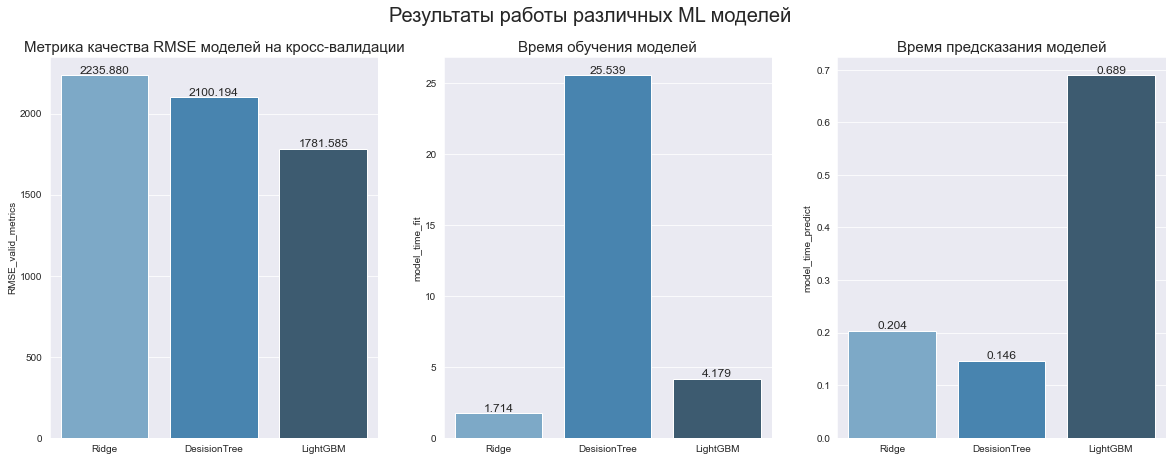

In [31]:
fig, axis = plt.subplots(1, 3, figsize=(20, 7))

# настройка шрифтов на графиках
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
plt.rc('figure', titlesize=20)  # fontsize of the figure title

# построение столбчатых диаграмм
sns.barplot(x=model_results.index, y=model_results['RMSE_valid_metrics'], ax=axis[0], palette="Blues_d")
sns.barplot(x=model_results.index, y=model_results['model_time_fit'], ax=axis[1], palette="Blues_d")
sns.barplot(x=model_results.index, y=model_results['model_time_predict'], ax=axis[2], palette="Blues_d")

# добавление дополнительной информации на графики
fig.suptitle('Результаты работы различных ML моделей')
axis[0].bar_label(axis[0].containers[0], fmt='%.3f')
axis[1].bar_label(axis[1].containers[0], fmt='%.3f')
axis[2].bar_label(axis[2].containers[0], fmt='%.3f')
axis[0].set_title('Метрика качества RMSE моделей на кросс-валидации')
axis[1].set_title('Время обучения моделей')
axis[2].set_title('Время предсказания моделей')
plt.show()

Из полученных графиков видно, что на тренировочных данных наилучший показатель метрики RMSE имеет модель градиентного бустинга. Выведем значение метрики RMSE модели LGBM на тестовой выборке.

In [32]:
print(f'RMSE на тестовой выборке равно {round(LGBR_RMSE)}')

RMSE на тестовой выборке равно 1756


### 4.2 Вывод:

Из построенных графиков видно следующее:

* Наилучший показатель качества модели RMSE на кросс-валидации имеет модель градиентного бустинга; 
* Наименьший показатель времени обучения имеет модель линейной регрессии;
* Наименьший показатель времени предсказания имеет модель решающего дерева;
* Наихудший показатель качества модели RMSE на кросс-валидации имеет модель линейной регрессии;
* Наибольший показатель времени обучения имеет модель решающего дерева;
* Наибольший показатель времени предсказания имеет модель градиентного бустинга;

Условиям задачи удовлетворяют модели решающего дерева и градиеньного бустинга. При этом градиетный бустинг работает быстрее.

## 5. Общий вывод:

В данном проекте проведен анализ данных о продаже автомобилей с пробегом сервиса «Не бит, не крашен». Обнаруженные в данных аномалии устранены. Для использования данных в моделях машинного обучения данные предобработаны. 

Для предсказания стоимости автомобиля построены три модели: линейная регрессия, решающее дерево, градиентный бустинг. В результате работы данных моделей получены данные о качестве предсказаний, времени их обучения и предсказания. На основе этих данных сделан вывод, что лучшая модель машинного обучения для данного проекта - модель градиентного бустинга "LightGBM" с наменьшим показателем метрики качества RMSE на тестовой выборке.